# 02 – Data Simulator (Reference Scenario)

In this notebook, we generate simulated data based on the *reference scenario* 
in our paper **"Handling underlying discrete variables with bivariate mixed hidden Markov models in NONMEM."**

It uses:
- `EmissionModel` (Eqs 1–6)
- `TransitionModel` (Eqs 7–10)

and produces:
- Hidden state sequences for each individual  
- Observed `FEV1` and `PRO` trajectories  
- Output dataset (`data/simulated/ref_scenario.csv`)


In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
print("✅ Path added:", os.path.abspath(os.path.join(os.getcwd(), "..")))

✅ Path added: /Users/user/Documents/Projects/Markov-Models/mHMM


In [2]:
import os
print ("CWD:", os.getcwd())

CWD: /Users/user/Documents/Projects/Markov-Models/mHMM/notebooks


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from src.emissions import EmissionModel
from src.transitions import TransitionModel
from src.simulator import simulate_reference_dataset

Simulate Hidden State Sequence

In [4]:
def simulate_states(T, init_probs, trans_mat, rng=None):
    """
    Simulate hidden state sequence S_0:T-1 given tranition matrix.
    
    Returns:
        states: array of shape (T,) with hidden states
    """

    rng = np.random.default_rng(rng)  # Use default random generator if none provided
    n_states = len(init_probs)

    states = np.zeros(T, dtype =int)
    states[0] = rng.choice(n_states, p=init_probs)

    for t in range(1, T):
        states[t] = rng.choice(n_states, p=trans_mat[states[t-1], :]) # Sample next state based on previous state
    return states

Generate emissions per time step

In [5]:
def simulate_observations(em_model, g, times, states, rng=None):
    """
    Generate observed (FEV1, PRO) given emission model, random effects g, time series 
    and state sequence
    """
    rng = np.random.default_rng(rng)  # Use default random generator if none provided
    obs = np.zeros((len(times), 2))  # Assuming 2D observations (FEV1, PRO)
    for i, t in enumerate(times):
        mu = np.array([
            em_model.individual_fev1(g, states[i]),
            em_model.individual_pro(g, t, states[i])
        ])
        cov = em_model.emission_cov(states[i])
        obs[i] = rng.multivariate_normal(mu, cov)
    return obs

Reference scenario parameters as in table 1 of the paper

In [6]:
#simulation settings
N_SUBJ = 100
T_WEEKS = 60
times = np.arange(T_WEEKS)
init_probs = np.array([0.9, 0.1])  # Initial state probabilities P(S0=Remission) = 0.9, P(S0=Exacerbation) = 0.1
rng = np.random.default_rng(123)  # For reproducibility

init_probs = np.array([0.9, 0.1])

em = EmissionModel(
    hFEV1R=2.0, hFEV1E=0.25,
    x2_FEV1R=0.03, x2_FEV1E=0.03,
    hPROR=2.5, hPROE=0.5,
    x2_PROR=0.09, x2_PROE=0.09,
    r2_FEV1=0.015, r2_PRO=0.05,
    qR=-0.33, qE=-0.33,
    PE=0.2, PHL=10.0
)

tm = TransitionModel(hpRE=0.05, hpER=0.15, slp=1.0, gpRE=0.0, gpER=0.0)
trans_mat = tm.transition_matrix() # Get transition matrix

In [7]:
records = []

for subj in tqdm(range(1, N_SUBJ + 1), desc= "Simulating subjects"):
    g= em.sample_individual_effects(rng=rng)  # Sample random effects for subject
    states = simulate_states(T_WEEKS, init_probs, trans_mat, rng=rng)  # Simulate hidden states
    obs = simulate_observations(em, g, times, states, rng=rng)  # Generate observations 

    for t, y in enumerate(obs):
        records.append({
            "ID": subj,
            "Week": t,
            "State": states[t],
            "FEV1": y[0],
            "PRO": y[1]
        })

df = pd.DataFrame(records) 
df.head() 

Simulating subjects: 100%|███████████████████| 100/100 [00:00<00:00, 375.24it/s]


,ID,Week,State,FEV1,PRO
0,1,0,0,1.651523,2.803810
1,1,1,1,1.678107,3.123523
2,1,2,1,1.348596,3.448288
3,1,3,0,1.620862,2.832255
4,1,4,1,1.501967,3.267526


In [8]:
output_path = "../data/simulated/ref_scenario.csv"
df.to_csv(output_path, index=False)
print(f"Simulated data saved to {output_path}")
print(df.shape)

Simulated data saved to ../data/simulated/ref_scenario.csv
(6000, 5)


Visualization

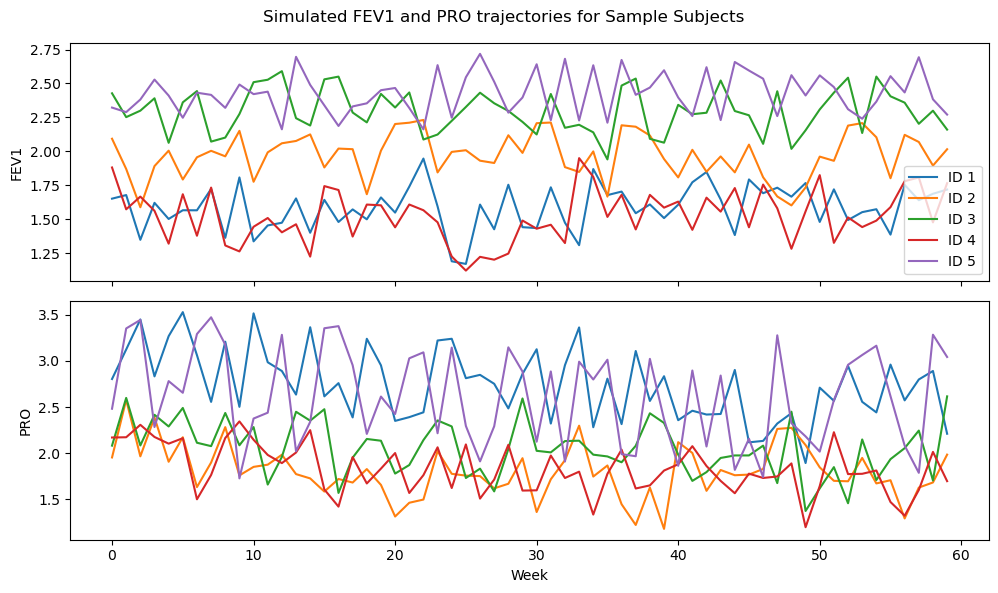

In [9]:
sample_subjects = df['ID'].unique()[:5] # Select first 5 subjects for visualization
fig, axes = plt.subplots(2, 1, figsize = (10,6), sharex=True)

for sid in sample_subjects:
    sub = df[df['ID'] == sid]
    axes[0].plot(sub["Week"], sub["FEV1"], label=f"ID {sid}")
    axes[1].plot(sub["Week"], sub["PRO"], label=f"ID {sid}")

axes[0].set_ylabel("FEV1")
axes[1].set_ylabel("PRO")
axes[1].set_xlabel("Week")
axes[0].legend()
plt.suptitle("Simulated FEV1 and PRO trajectories for Sample Subjects")
plt.tight_layout()
plt.show()

## Interpretation

The figure shows simulated FEV1 (lung function) and PRO (patient-reported outcome) trajectories over 60 weeks for 5 representative subjects.

Top panel (FEV1):
FEV1 levels fluctuate moderately across time, reflecting random within-subject variability and transitions between latent health states (Remission vs Exacerbation). Subjects show distinct baseline levels due to individual random effects (gFEV1R, gFEV1E).

Bottom panel (PRO):
PRO values display greater variability and a gradual decline in some subjects, consistent with time-dependent placebo and exacerbation effects.
The correlation between FEV1 and PRO trends aligns with the emission model’s state-specific covariance.

#### The trajectories demonstrate biologically plausible dynamics under the reference scenario, which is stable remission periods interspersed with temporary declines during exacerbation episode.

## Summary

Thus far we have:
-Simulated hidden state sequences for 100 subjects over 60 weeks

-Generated observed (FEV1, PRO) data from the emission model

-Saved the dataset to csv

Next steps:
Open the "03_estimation.ipynb" notebook to fit this dataset using the forward algorithm (Max Likelihood Estimation) or a 
Bayesian approach (Stanpy)